In [1]:
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

In [2]:
df = pd.read_csv(r"Datasets and Models/cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.shape

(569, 32)

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
total_memory_usage = df.memory_usage().sum() / 1024**2
print(f"Total Memory usage: {total_memory_usage: .2f} MB")

Total Memory usage:  0.14 MB


In [6]:
df.duplicated().sum()

0

In [7]:
# for this analysis the id feature is not useful

df.drop("id", axis=1, inplace=True)

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [9]:
df.nunique()

diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
dtype: int64

In [10]:
def count_outliers(dframe):
    outliers = {}
    for col in dframe.select_dtypes(include='number').columns:
        q1 = dframe[col].quantile(0.25)
        q3 = dframe[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)
        outliers[col] = len(dframe[(dframe[col] > upper_bound) | (dframe[col]  < lower_bound)])
    return outliers
        

In [11]:
outliers = count_outliers(df)
outliers

{'radius_mean': 14,
 'texture_mean': 7,
 'perimeter_mean': 13,
 'area_mean': 25,
 'smoothness_mean': 6,
 'compactness_mean': 16,
 'concavity_mean': 18,
 'concave points_mean': 10,
 'symmetry_mean': 15,
 'fractal_dimension_mean': 15,
 'radius_se': 38,
 'texture_se': 20,
 'perimeter_se': 38,
 'area_se': 65,
 'smoothness_se': 30,
 'compactness_se': 28,
 'concavity_se': 22,
 'concave points_se': 19,
 'symmetry_se': 27,
 'fractal_dimension_se': 28,
 'radius_worst': 17,
 'texture_worst': 5,
 'perimeter_worst': 15,
 'area_worst': 35,
 'smoothness_worst': 7,
 'compactness_worst': 16,
 'concavity_worst': 12,
 'concave points_worst': 0,
 'symmetry_worst': 23,
 'fractal_dimension_worst': 24}

In [12]:
the_list = []
total_rows = df.shape

the_list = [(key, round((value / total_rows[0]) * 100, 2)) for key, value in outliers.items()]

the_list

[('radius_mean', 2.46),
 ('texture_mean', 1.23),
 ('perimeter_mean', 2.28),
 ('area_mean', 4.39),
 ('smoothness_mean', 1.05),
 ('compactness_mean', 2.81),
 ('concavity_mean', 3.16),
 ('concave points_mean', 1.76),
 ('symmetry_mean', 2.64),
 ('fractal_dimension_mean', 2.64),
 ('radius_se', 6.68),
 ('texture_se', 3.51),
 ('perimeter_se', 6.68),
 ('area_se', 11.42),
 ('smoothness_se', 5.27),
 ('compactness_se', 4.92),
 ('concavity_se', 3.87),
 ('concave points_se', 3.34),
 ('symmetry_se', 4.75),
 ('fractal_dimension_se', 4.92),
 ('radius_worst', 2.99),
 ('texture_worst', 0.88),
 ('perimeter_worst', 2.64),
 ('area_worst', 6.15),
 ('smoothness_worst', 1.23),
 ('compactness_worst', 2.81),
 ('concavity_worst', 2.11),
 ('concave points_worst', 0.0),
 ('symmetry_worst', 4.04),
 ('fractal_dimension_worst', 4.22)]

In [13]:
def get_column_ranges(dframe):
    ranges = {}
    for column in dframe.select_dtypes(include='number').columns:
        column_min = dframe[column].min()
        column_max = dframe[column].max()
        column_range = column_max - column_min
        ranges[column] = [column_min, column_max, column_range]
    return ranges

In [14]:
ranges = get_column_ranges(df)

for column, values in ranges.items():
    print(f"Column: {column}")
    print(f"Minimum: {values[0]}, Maximum: {values[1]} Range: {values[2]:.2f}")
    print()

Column: radius_mean
Minimum: 6.981, Maximum: 28.11 Range: 21.13

Column: texture_mean
Minimum: 9.71, Maximum: 39.28 Range: 29.57

Column: perimeter_mean
Minimum: 43.79, Maximum: 188.5 Range: 144.71

Column: area_mean
Minimum: 143.5, Maximum: 2501.0 Range: 2357.50

Column: smoothness_mean
Minimum: 0.05263, Maximum: 0.1634 Range: 0.11

Column: compactness_mean
Minimum: 0.01938, Maximum: 0.3454 Range: 0.33

Column: concavity_mean
Minimum: 0.0, Maximum: 0.4268 Range: 0.43

Column: concave points_mean
Minimum: 0.0, Maximum: 0.2012 Range: 0.20

Column: symmetry_mean
Minimum: 0.106, Maximum: 0.304 Range: 0.20

Column: fractal_dimension_mean
Minimum: 0.04996, Maximum: 0.09744 Range: 0.05

Column: radius_se
Minimum: 0.1115, Maximum: 2.873 Range: 2.76

Column: texture_se
Minimum: 0.3602, Maximum: 4.885 Range: 4.52

Column: perimeter_se
Minimum: 0.757, Maximum: 21.98 Range: 21.22

Column: area_se
Minimum: 6.802, Maximum: 542.2 Range: 535.40

Column: smoothness_se
Minimum: 0.001713, Maximum: 0.031

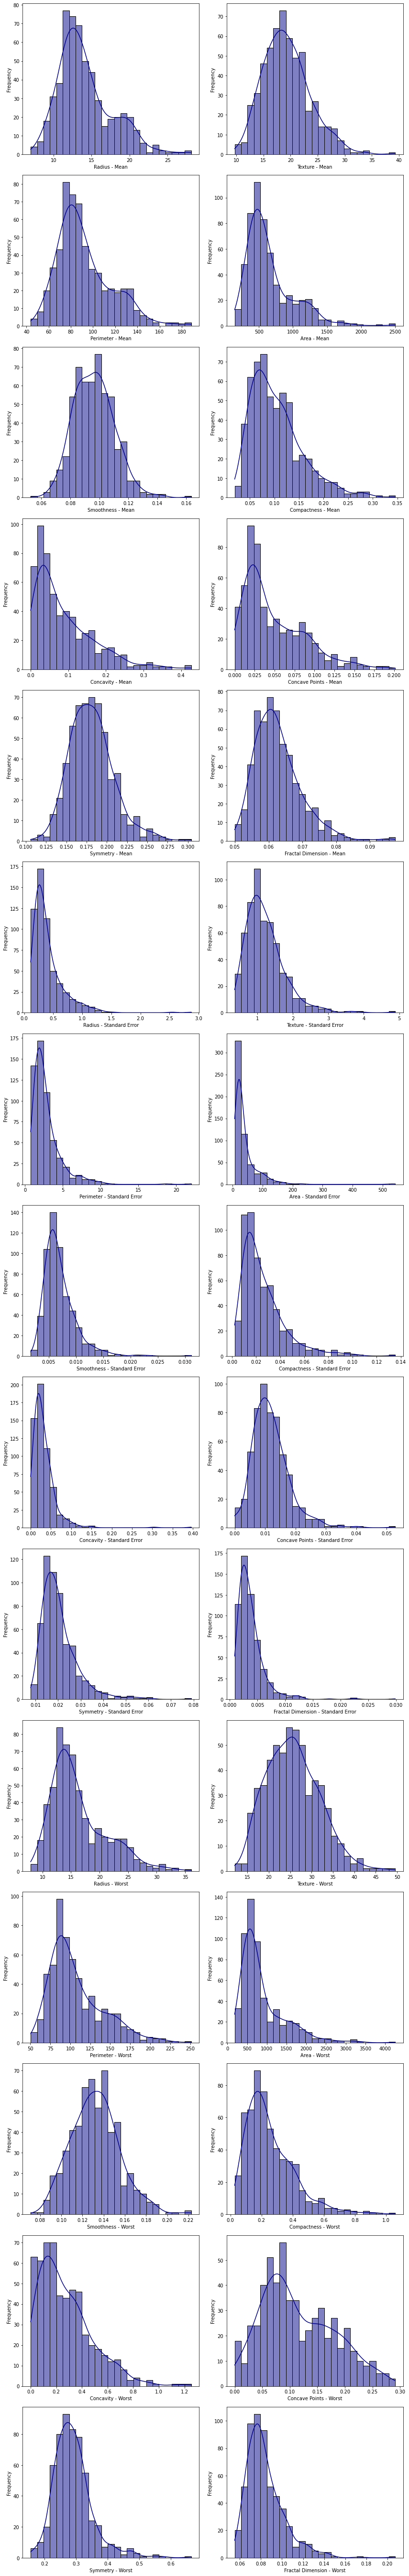

In [15]:
num_plots = len(df.iloc[:, 1:].columns)

num_rows = (num_plots + 1) // 2 # Number of rows for subplots 

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))

for i, feature in enumerate(df.iloc[:, 1:].columns):
    data = df.copy()

    row = i // 2
    col = i % 2
    ax = axes[row, col]

    sns.histplot(data[feature], ax=ax, bins=25, kde=True, color='darkblue')
    ax.set_xlabel(feature.replace('_', ' - ').title().replace('Se', 'Standard Error').replace('Fractal - Dimension', 'Fractal Dimension'))
    ax.set_ylabel("Frequency")

if num_plots < num_rows * 2:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.show()


In [17]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
scaler  = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
y_test.value_counts()

diagnosis
B    67
M    47
Name: count, dtype: int64

<Axes: ylabel='count'>

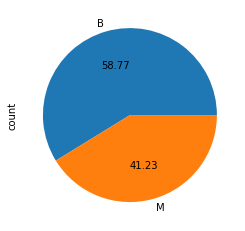

In [22]:
y_test.value_counts().plot.pie(autopct = '%.2f')

In [21]:
y_train.value_counts()

diagnosis
B    290
M    165
Name: count, dtype: int64

<Axes: ylabel='count'>

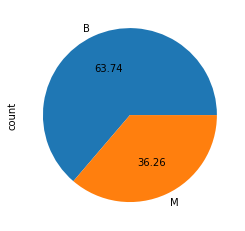

In [23]:
y_train.value_counts().plot.pie(autopct = '%.2f')

In [24]:
ros = RandomOverSampler(sampling_strategy="not majority")
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

In [25]:
y_res.value_counts()

diagnosis
B    290
M    290
Name: count, dtype: int64

<Axes: ylabel='count'>

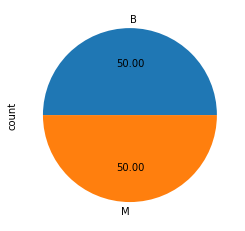

In [26]:
y_res.value_counts().plot.pie(autopct='%.2f')

In [27]:
classifier = SVC(kernel="rbf")
classifier.fit(X_res, y_res)

SVC()

In [28]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)